# 1. Object Oriented Programming (OOP) - cont.

## 1.1. Deeper Dive Into OOP
* 지난시간에는 절차지향적으로 작성된 프로그램을 객체지향적으로 재작성 해 보았습니다.
* 지난시간에 작성했던 예제를 가져와보겠습니다:

In [5]:
from PIL import Image, ImageChops
import numpy as np
import cv2
from matplotlib.pyplot import imshow
import os, sys

class ImagePreProcessor:
    def __init__(self, size=224):
        self.size = size
        
    def white_space_removal(self, image):
        bg = Image.new(image.mode, image.size, image.getpixel((0,0)))
        diff = ImageChops.difference(image, bg)
        diff = ImageChops.add(diff, diff, 1.0, -100)
        bbox = diff.getbbox()
        if bbox:
            return image.crop(bbox)
        else:
            return image
    
    def normalization(self, image):
        image = np.array(image) 
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        height, width, _ = image.shape
        
        if height >= self.size:
            if width <= self.size: # case 1(height >= size, width <= size)
                ratio = float(self.size) / float(self.size)
                img = cv2.resize(image, (int(width * ratio), self.size))
            else:  # case 2(height >= size, width > size)
                idx = np.argmax([height, width])
                if idx == 0:  # case 2-1(height >= size, width > size and height > width)
                    ratio = float(self.size) / float(height)
                    img = cv2.resize(image, (int(width * ratio), self.size))
                else:  # case 2-1(height >= size, width > size and width > height)
                    ratio = float(self.size) / float(width)
                    img = cv2.resize(image, (self.size, int(height * ratio)))
        else:
            if width >= self.size:  # case 3(height < size, width >= size)
                ratio = float(self.size) / float(width)
                img = cv2.resize(image, (self.size, int(height * ratio)))

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)

        width, height = img.size
        bg = Image.new('RGB', (self.size, self.size), (255, 255, 255))
        if width >= self.size or height >= self.size:
            height_start = int((width - height) / 2)
            width_start = int((height - width) / 2)
            if not width == height:
                # Paste image to background image
                if width > height:
                    bg.paste(img, (0, height_start))
                else:
                    bg.paste(img, (width_start, 0))
            else:
                bg = img
        else:
            width_start = int((self.size - width) / 2)
            height_start = int((self.size - height) / 2)
            bg.paste(img, (width_start, height_start))
            
        return bg
    
    def color_inversion(self, image):
        bg_array = np.array(image)
        inverted_img = 255 - bg_array
        inverted_img = cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB)
        return inverted_img

In [3]:
path = './image.jpg'
image = Image.open(path).convert('RGB')

ip = ImagePreProcessor(224)
a = ip.white_space_removal(image)
b = ip.normalization(a)
c = ip.color_inversion(b)

* 좀 정리가 된것 같지만 아직 개선의 여지가 있어보이지 않나요?
* 만약 ImagePreProcessor 의 함수들을 또 객체로 만들면 어떨까요?
* 거기에 추상클래스 라는것을 알아봅시다.

In [219]:
from abc import ABC, abstractmethod

In [61]:
class ImageRepositoryBase(ABC):
    def process_image(self):
        self.read_image()
        self.white_space_removal()
        self.normalization()
        self.color_inversion()
        return
        
        
    @abstractmethod
    def white_space_removal(self):
        raise NotImplementedError
        
    @abstractmethod
    def normalization(self):
        raise NotImplementedError
        
    @abstractmethod
    def color_inversion(self):
        raise NotImplementedError

In [143]:
class BaseProcessor:
    def __init__(self, image):
        self.image = image
        self.processed = None
        
    @abstractmethod
    def process(self):
        raise NotImplementedError
    
    @abstractmethod
    def getter(self):
        raise NotImplementedError
    
    @abstractmethod
    def setter(self, image):
        raise NotImplementedError

In [225]:
class WhiteSpaceRemover(BaseProcessor):
    def __init__(self, image):
        super().__init__(image)
        
    def process(self):
        bg = Image.new(self.image.mode, image.size, image.getpixel((0,0)))
        diff = ImageChops.difference(self.image, bg)
        diff = ImageChops.add(diff, diff, 1.0, -100)
        bbox = diff.getbbox()
        if bbox:
            self.processed = self.image.crop(bbox)
        else:
            self.processed = self.image
    
    def getter(self):
        return self.processed
    

    def setter(self, image):
        self.processed = image

In [226]:
class Normalizer(BaseProcessor):
    def __init__(self, image, size):
        super().__init__(image)
        self.size = size
    
    def process(self):
        image = np.array(self.image) 
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        height, width, _ = image.shape
        
        if height >= self.size:
            if width <= self.size: # case 1(height >= size, width <= size)
                ratio = float(self.size) / float(self.size)
                img = cv2.resize(image, (int(width * ratio), self.size))
            else:  # case 2(height >= size, width > size)
                idx = np.argmax([height, width])
                if idx == 0:  # case 2-1(height >= size, width > size and height > width)
                    ratio = float(self.size) / float(height)
                    img = cv2.resize(image, (int(width * ratio), self.size))
                else:  # case 2-1(height >= size, width > size and width > height)
                    ratio = float(self.size) / float(width)
                    img = cv2.resize(image, (self.size, int(height * ratio)))
        else:
            if width >= self.size:
                ratio = float(self.size) / float(width)
                img = cv2.resize(image, (self.size, int(height * ratio)))

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)

        width, height = img.size
        bg = Image.new('RGB', (self.size, self.size), (255, 255, 255))
        if width >= self.size or height >= self.size:
            height_start = int((width - height) / 2)
            width_start = int((height - width) / 2)
            if not width == height:
                # Paste image to background image
                if width > height:
                    bg.paste(img, (0, height_start))
                else:
                    bg.paste(img, (width_start, 0))
            else:
                bg = img
        else:
            width_start = int((self.size - width) / 2)
            height_start = int((self.size - height) / 2)
            bg.paste(img, (width_start, height_start))
    
        self.processed = bg
        
        
    def getter(self):
        return self.processed
    

    def setter(self, image):
        self.processed = image

In [227]:
class ColorInvertor(BaseProcessor):
    def __init__(self, image):
        super().__init__(image)
        
        
    def process(self):
        bg_array = np.array(self.image)
        inverted_img = 255 - bg_array
        inverted_img = cv2.cvtColor(inverted_img, cv2.COLOR_BGR2RGB)
        self.processed = inverted_img
    
    def getter(self):
        return self.processed
    
    def setter(self, image):
        self.processed = image

In [263]:
# class ImageProcessorOne(ImageRepositoryBase):
class ImageProcessor:
    def __init__(self, path):
        _image = Image.open(path).convert('RGB')
        self._image = image
        
        
    def white_space_removal(self):
        wsr = WhiteSpaceRemover(self._image)
        wsr.process()
        self._image = wsr.getter()
        # return self._image
    
    
    def normalization(self):
        norm = Normalizer(self._image, size=224)
        norm.process()
        self._image = norm.getter()
        # return self._image
    
    
    def color_inversion(self):
        cvt = ColorInvertor(self._image)
        cvt.process()
        self._image = cvt.getter()
        # return self._image
    
    
    def show_image(self):
        if not isinstance(self._image, PIL.Image.Image):
            self._image = Image.fromarray(self._image)
        return self._image

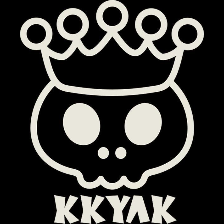

In [264]:
path = './image.jpg'
ip = ImageProcessor(path)
ip.white_space_removal()
ip.normalization()
ip.color_inversion()
ip.show_image()

In [316]:
class Program:
    def __init__(self, path):
        self._ip = ImageProcessor(path)

    def start(self):
        while True:
            choice = int(input())
            if choice == 1:
                self._ip.white_space_removal()
                return self._ip.show_image()
            
            elif choice ==2:
                self._ip.white_space_removal()
                self._ip.normalization()
                return self._ip.show_image()
            
            elif choice ==3:
                self._ip.white_space_removal()
                self._ip.normalization()
                self._ip.color_inversion()
                return self._ip.show_image()
            elif choice ==4:
                return self._ip.show_image()
            else:
                print('wrong input!')

3


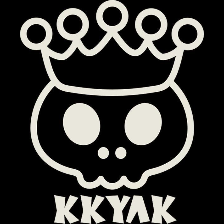

In [319]:
path = './image.jpg'
program = Program(path)
program.start()